In [2]:
import os
import datetime
import pytz

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from scipy.signal import find_peaks

In [3]:
def is_gzip_file(filepath):
    with open(filepath, 'rb') as f:
        return f.read(2) == b'\x1f\x8b'
def display_all(df):
    plot_cols = df.columns
    plot_features = df[plot_cols]
    plot_features.index = df.index
    _ = plot_features.plot(subplots=True)

    plot_features = df[plot_cols][:960]
    plot_features.index = df.index[:960]
    _ = plot_features.plot(subplots=True)

In [4]:
def fill_with_lagged_data(df, periods_back=None):
    """
    Fill missing/zero values with data from specified periods back
    For 15-min data, one year = 365 * 24 * 4 = 35,040 periods
    """
    
    if periods_back is None:
        # Estimate periods for one year based on frequency
        freq = pd.infer_freq(df.index)
        if freq and '15T' in freq:
            periods_back = 365 * 24 * 4  # One year of 15-min data
        elif freq and 'H' in freq:
            periods_back = 365 * 24  # One year of hourly data
        else:
            periods_back = 365  # Default to daily
    
    filled_df = df.copy()
    
    for col in filled_df.columns:
        # Create a shifted version (one year ago)
        lagged_series = filled_df[col].shift(periods_back)
        
        # Create condition: where current value is 0 or NaN
        mask = (filled_df[col].isna()) | (filled_df[col] == 0)
        
        # Fill using the lagged data where the condition is met
        filled_df[col] = filled_df[col].mask(mask, lagged_series)
    
    return filled_df

In [5]:
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False

In [87]:
csv_path = tf.keras.utils.get_file(
    origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/merge_15min_filled.csv.zip')
    #origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/export_device_1_basic_aggregated_1hour.csv.gz')
csv_path

9744323/9744323 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step


'/Users/watcharinsarachai/.keras/datasets/merge_15min_filled.csv.zip'

In [88]:
if is_gzip_file(csv_path):
  # Read the data directly into a pandas DataFrame
  df = pd.read_csv(csv_path, compression='gzip')
else:
  # Read the data without compression
  df = pd.read_csv(csv_path)

row_count = df.shape[0]
print(f"Total rows: {row_count}")
df.head(5)

Total rows: 138238


,Unnamed: 0,ambient_temperature,current_power,current_value_of_consumption,external_energy_supply,grid_feed_in,internal_power_supply,self_consumption,temperature_measurement,total_irradiation,...,sp,sshf,ssr,ssrd,str,strd,t2m,tp,u10,v10
0,2021-11-06 11:15:00,30.288889,46519.355556,37280.422222,0.0,9238.933333,37280.422222,37280.422222,58.022222,798.444444,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
1,2021-11-06 11:30:00,30.076923,47600.714286,39472.626374,0.0,9397.756098,39132.406593,39132.406593,58.263736,812.571429,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
2,2021-11-06 11:45:00,30.629213,47056.988764,32669.393258,0.0,14387.595506,32669.393258,32669.393258,57.235955,807.224719,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
3,2021-11-06 12:00:00,31.021978,48415.835165,36126.516484,0.0,12289.318681,36126.516484,36126.516484,56.846154,817.527473,...,96169.262638,-1.129156e+06,1.577950e+07,1.890126e+07,-4.231913e+06,1.548664e+07,297.380576,4.261732e-07,0.378476,0.374936
4,2021-11-06 12:15:00,31.831461,49345.404494,36879.966292,0.0,12465.438202,36879.966292,36879.966292,55.842697,816.651685,...,96169.262638,-1.129156e+06,1.577950e+07,1.890126e+07,-4.231913e+06,1.548664e+07,297.380576,4.261732e-07,0.378476,0.374936


In [89]:
df.pop('current_value_of_consumption')
df.pop('external_energy_supply')
df.pop('grid_feed_in')
df.pop('internal_power_supply')
df.pop('self_consumption')
df.head(5)

,Unnamed: 0,ambient_temperature,current_power,temperature_measurement,total_irradiation,utci_mean,cc,q,r,t,...,sp,sshf,ssr,ssrd,str,strd,t2m,tp,u10,v10
0,2021-11-06 11:15:00,30.288889,46519.355556,58.022222,798.444444,302.213731,0.0,0.011205,63.667006,293.487773,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
1,2021-11-06 11:30:00,30.076923,47600.714286,58.263736,812.571429,302.213731,0.0,0.011205,63.667006,293.487773,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
2,2021-11-06 11:45:00,30.629213,47056.988764,57.235955,807.224719,302.213731,0.0,0.011205,63.667006,293.487773,...,96116.322417,-1.159087e+06,1.577950e+07,1.890126e+07,-3.907932e+06,1.423682e+07,298.020567,4.261732e-07,0.695138,0.362603
3,2021-11-06 12:00:00,31.021978,48415.835165,56.846154,817.527473,299.223424,0.0,0.011366,65.189689,293.320821,...,96169.262638,-1.129156e+06,1.577950e+07,1.890126e+07,-4.231913e+06,1.548664e+07,297.380576,4.261732e-07,0.378476,0.374936
4,2021-11-06 12:15:00,31.831461,49345.404494,55.842697,816.651685,299.223424,0.0,0.011366,65.189689,293.320821,...,96169.262638,-1.129156e+06,1.577950e+07,1.890126e+07,-4.231913e+06,1.548664e+07,297.380576,4.261732e-07,0.378476,0.374936


In [90]:
# Rename the first column to 'new_name'
df = df.rename(columns={df.columns[0]: 'datetime'})

In [91]:
try:
    df['datetime'] = pd.to_datetime(df['datetime'])
    print("✅ แปลง Datetime สำเร็จด้วย pd.to_datetime() แบบอัตโนมัติ")
except Exception as e:
    print(f"❌ การแปลงแบบอัตโนมัติล้มเหลว: {e}")
    try:
        df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
        print("✅ แปลง Datetime สำเร็จด้วย format '%Y-%m-%d %H:%M:%S'")
    except Exception as e2:
        print(f"❌ การแปลงด้วย format ล้มเหลว: {e2}")
        # ใช้วิธีสุดท้าย - แปลงแบบ errors='coerce'
        df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
        print("⚠️  แปลง Datetime ด้วย errors='coerce' (ค่าที่แปลงไม่ได้จะเป็น NaT)")

✅ แปลง Datetime สำเร็จด้วย pd.to_datetime() แบบอัตโนมัติ


In [92]:
df = df.sort_values('datetime').reset_index(drop=True)

In [93]:
# Convert 'timestamp' column to datetime
df = df.set_index('datetime')

print(df.index.year.unique())
print(df.index.year.value_counts())

Index([2021, 2022, 2023, 2024, 2025], dtype='int32', name='datetime')
datetime
2024    35136
2022    35040
2023    35040
2025    27691
2021     5331
Name: count, dtype: int64


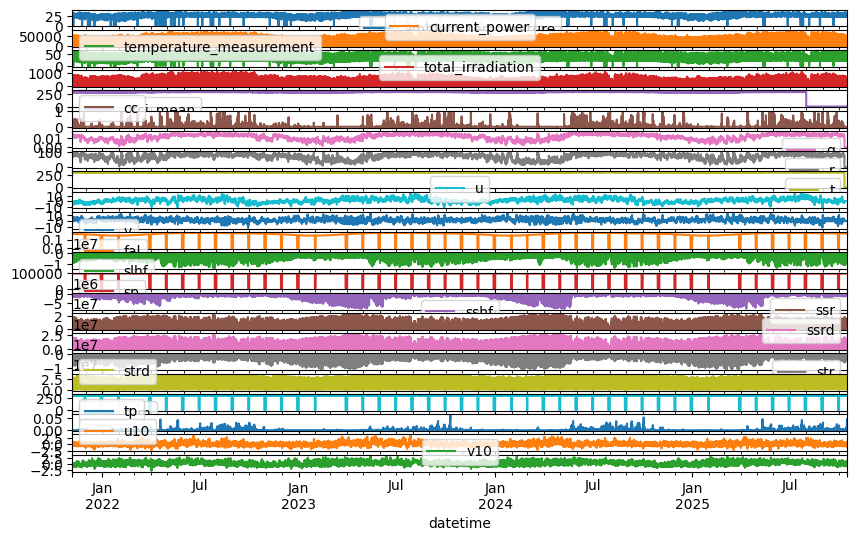

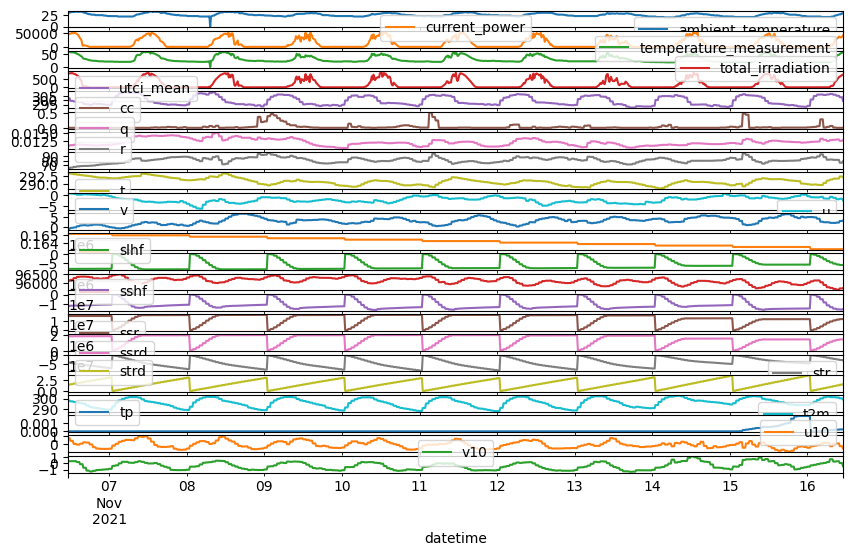

In [94]:
display_all(df)

In [95]:
print("\nจำนวน Missing Values ก่อนทำการ fill:")
for col in df.columns:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"  {col}: {missing_count} missing values")


จำนวน Missing Values ก่อนทำการ fill:


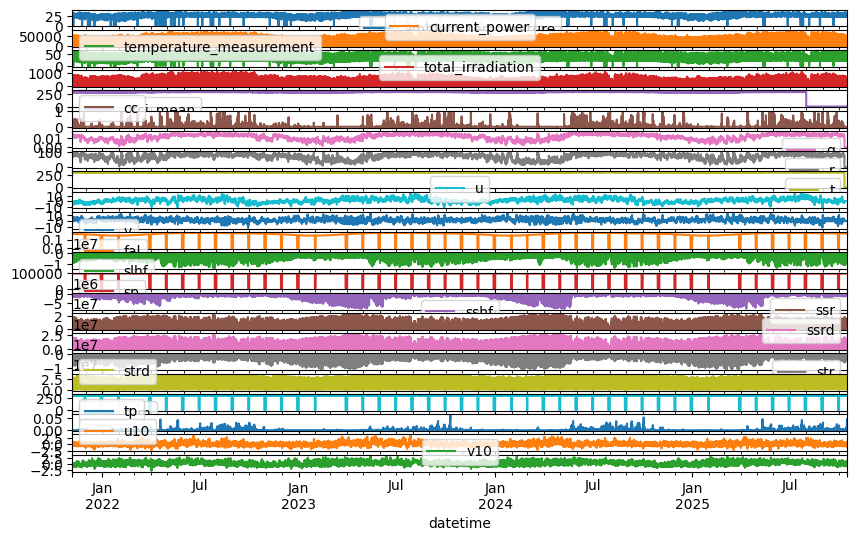

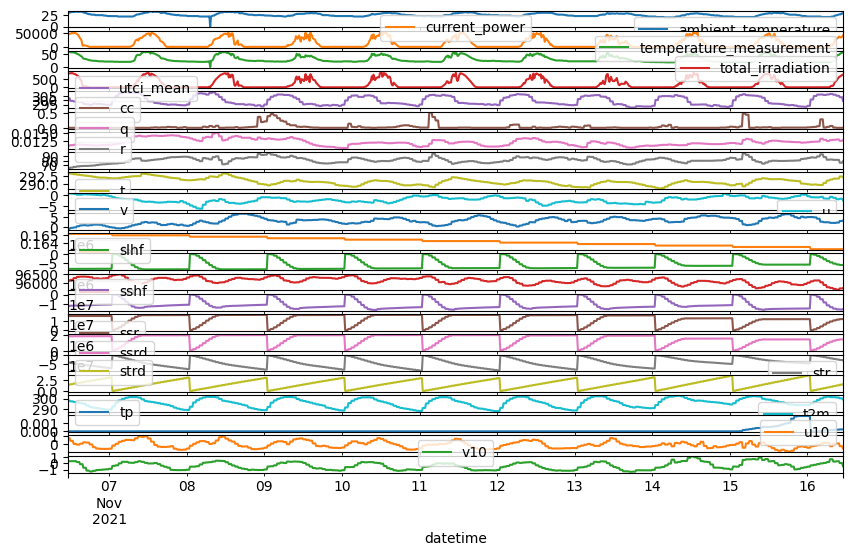

In [96]:
# For 15-minute data, one day = 96 points, one year ≈ 35,040 points
limit_value = 35040  # approximately one year of 15-minute data

for col in df.columns:
    df[col] = df[col].bfill(limit=limit_value)
    
display_all(df)

Text(0, 0.5, 'Current Power')

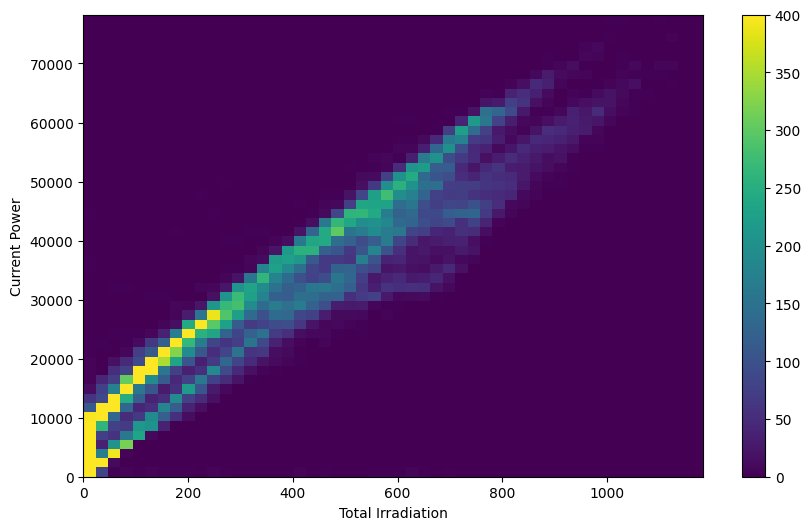

In [97]:
plt.hist2d(df['total_irradiation'], df['current_power'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Total Irradiation')
plt.ylabel('Current Power')

Text(0, 0.5, 'Current Power')

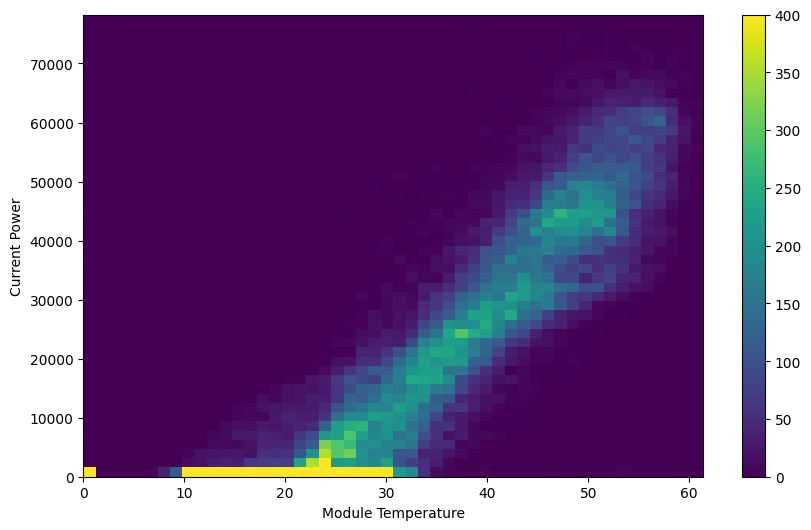

In [98]:
plt.hist2d(df['temperature_measurement'], df['current_power'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Module Temperature')
plt.ylabel('Current Power')

Text(0, 0.5, 'Current Power')

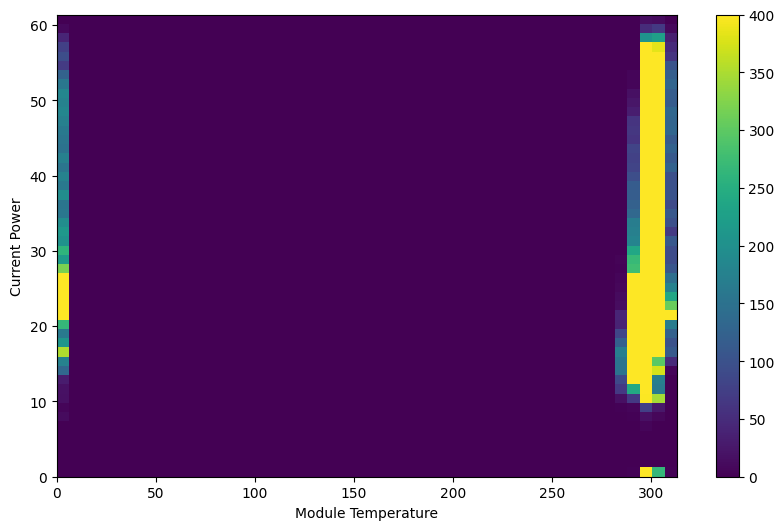

In [99]:
plt.hist2d(df['t2m'], df['temperature_measurement'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Module Temperature')
plt.ylabel('Current Power')

In [100]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)
timestamp_s

Index([1636197300.0, 1636198200.0, 1636199100.0, 1636200000.0, 1636200900.0,
       1636201800.0, 1636202700.0, 1636203600.0, 1636204500.0, 1636205400.0,
       ...
       1760602500.0, 1760603400.0, 1760604300.0, 1760605200.0, 1760606100.0,
       1760607000.0, 1760607900.0, 1760608800.0, 1760609700.0, 1760610600.0],
      dtype='float64', name='datetime', length=138238)

In [101]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ambient_temperature,138238.0,2.583504e+01,5.150631e+00,0.000000e+00,2.310989e+01,2.600000e+01,2.913483e+01,4.001099e+01
current_power,138238.0,1.305281e+04,1.815287e+04,0.000000e+00,0.000000e+00,0.000000e+00,2.526932e+04,7.825989e+04
temperature_measurement,138238.0,2.972648e+01,1.188849e+01,0.000000e+00,2.200000e+01,2.506593e+01,3.835227e+01,6.137363e+01
total_irradiation,138238.0,1.558014e+02,2.449202e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.658961e+02,1.183055e+03
utci_mean,138238.0,2.841147e+02,6.759370e+01,0.000000e+00,2.950198e+02,2.991934e+02,3.050845e+02,3.170079e+02
cc,138238.0,4.359805e-02,1.272938e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.337181e-02,1.000000e+00
q,138238.0,1.155237e-02,3.095912e-03,0.000000e+00,9.139406e-03,1.240514e-02,1.411958e-02,1.746720e-02
r,138238.0,7.105046e+01,1.935290e+01,0.000000e+00,5.918899e+01,7.650769e+01,8.576274e+01,1.018295e+02
t,138238.0,2.912035e+02,1.826893e+01,0.000000e+00,2.909458e+02,2.922866e+02,2.937318e+02,3.033400e+02
u,138238.0,1.579913e+00,3.781639e+00,-1.205189e+01,-1.115728e+00,1.584174e+00,4.060733e+00,1.637189e+01


In [102]:
day = 24*60*60
year = (365.2425)*day
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Total data points 138238
Total data points in a day 96.0


Text(0.5, 1.0, 'Time of day signal')

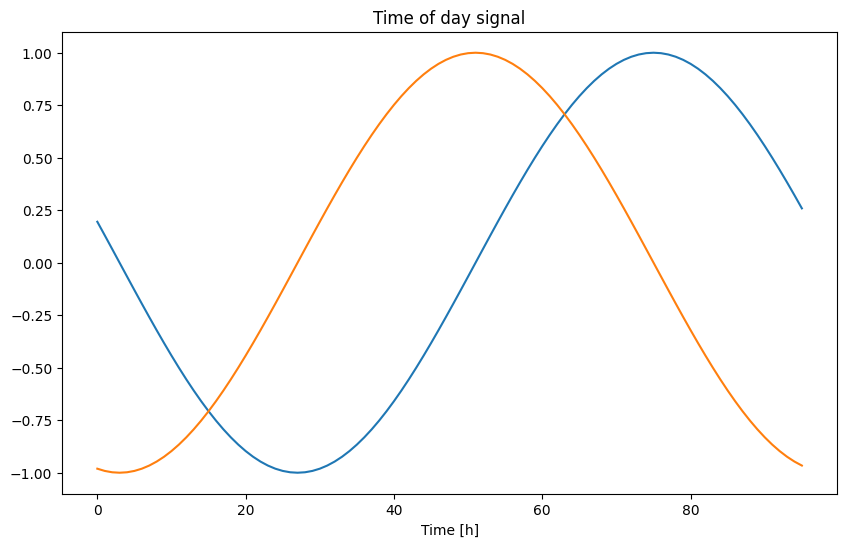

In [103]:
print(f"Total data points {len(df)}")
print(f"Total data points in a day {24*60/15}")

plt.plot(np.array(df['Day sin'])[:96])
plt.plot(np.array(df['Day cos'])[:96])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [104]:
def manual_rfftfreq(n_samples, d):
    """
    Manual implementation of np.fft.rfftfreq()
    
    Parameters:
    n_samples (int): Number of samples in the original time domain signal
    d (float): Sample spacing (time between samples) in seconds
    
    Returns:
    numpy array: Array of frequencies corresponding to FFT output
    """
    # Calculate the sample rate (samples per second)
    sample_rate = 1.0 / d
    
    # For real FFT, we get n//2 + 1 frequency bins (including DC component)
    num_freq_bins = n_samples // 2 + 1
    
    # Calculate frequency increment between bins
    freq_increment = sample_rate / n_samples
    
    # Generate frequencies from 0 to Nyquist frequency
    frequencies = np.arange(num_freq_bins) * freq_increment
    
    return frequencies

# Example usage:
n_samples = len(df['current_power'])
sample_period = 15 * 60  # 15 minutes in seconds

# Manual calculation
manual_frequencies = manual_rfftfreq(n_samples, sample_period)
manual_frequencies[-1]

np.float64(0.0005555555555555556)

In [105]:
# Verify against NumPy's implementation
numpy_frequencies = np.fft.rfftfreq(n_samples, d=sample_period)

# Compare the first few values
print("Manual calculation:", manual_frequencies[:5])
print("NumPy calculation :", numpy_frequencies[:5])

Manual calculation: [0.00000000e+00 8.03766773e-09 1.60753355e-08 2.41130032e-08
 3.21506709e-08]
NumPy calculation : [0.00000000e+00 8.03766773e-09 1.60753355e-08 2.41130032e-08
 3.21506709e-08]


In [106]:
# Find peaks manually
def find_peaks_manual(x, min_prominence_ratio=0.01):
    peaks = []
    for i in range(1, len(x)-1):
        if x[i] > x[i-1] and x[i] > x[i+1]:
            peaks.append(i)

    print(peaks)
    
    max_val = x.max()
    threshold = max_val * min_prominence_ratio
    peaks = [p for p in peaks if x[p] > threshold]
    
    return np.array(peaks)

In [107]:
fft = tf.signal.rfft(df['current_power'])
max_val = np.abs(fft).max()
f_per_dataset = np.arange(0, len(fft))
years_per_dataset = n_samples/(sample_period)

f_per_year = f_per_dataset/years_per_dataset

In [108]:
# Get amplitude spectrum
amplitude_spectrum = np.abs(fft.numpy())  # Convert to NumPy array

# Find the peaks
peaks = find_peaks_manual(amplitude_spectrum)
# Convert peak indices to frequencies
peak_frequencies = f_per_year[peaks]

[4, 8, 12, 15, 17, 20, 24, 26, 28, 31, 35, 39, 43, 49, 55, 60, 62, 66, 69, 71, 73, 76, 79, 83, 86, 88, 91, 94, 99, 102, 107, 110, 112, 114, 117, 122, 124, 126, 130, 134, 138, 143, 146, 150, 152, 154, 160, 162, 166, 169, 173, 177, 181, 185, 187, 189, 192, 194, 198, 201, 204, 209, 213, 215, 217, 221, 225, 229, 231, 236, 238, 240, 244, 246, 249, 251, 253, 256, 258, 260, 262, 264, 267, 270, 272, 276, 280, 284, 286, 288, 292, 296, 298, 300, 303, 305, 307, 310, 315, 317, 319, 323, 327, 335, 337, 340, 343, 347, 351, 355, 358, 360, 362, 366, 368, 370, 372, 375, 380, 382, 384, 386, 388, 390, 394, 396, 398, 400, 403, 405, 408, 410, 414, 417, 421, 423, 426, 429, 433, 437, 441, 444, 448, 450, 452, 454, 456, 460, 465, 467, 469, 473, 476, 479, 481, 483, 485, 489, 492, 494, 498, 500, 503, 506, 508, 512, 516, 518, 524, 526, 528, 530, 533, 536, 538, 540, 545, 547, 553, 556, 564, 567, 572, 575, 578, 581, 583, 585, 587, 589, 592, 595, 597, 599, 601, 604, 606, 608, 610, 613, 615, 618, 621, 625, 628, 631, 

In [109]:
# Convert frequencies to periods
peak_periods = 1 / peak_frequencies

# Sort peaks by amplitude
sorted_indices = np.argsort(-amplitude_spectrum[peaks])
peaks = peaks[sorted_indices]
peak_frequencies = peak_frequencies[sorted_indices]
peak_periods = peak_periods[sorted_indices]

# Show results (top 5 peaks)
for i, (freq, period) in enumerate(zip(peak_frequencies[:5], peak_periods[:5])):
    print(f"Peak {i+1}: Frequency = {freq:.4f} cycles/year")
    
    # Convert to more intuitive units
    days = period * 365.25
    if days < 1:
        print(f"    Period ≈ {days*24:.2f} hours")
    elif days < 30:
        print(f"    Period ≈ {days:.2f} days")
    else:
        print(f"    Period ≈ {period*12:.2f} months")

Peak 1: Frequency = 9.3751 cycles/year
    Period ≈ 1.28 months
Peak 2: Frequency = 18.7503 cycles/year
    Period ≈ 19.48 days
Peak 3: Frequency = 28.1254 cycles/year
    Period ≈ 12.99 days
Peak 4: Frequency = 0.0260 cycles/year
    Period ≈ 460.79 months
Peak 5: Frequency = 9.4012 cycles/year
    Period ≈ 1.28 months


Text(0.5, 1.0, 'Frequency Spectrum of Current Power with Peak Frequencies')

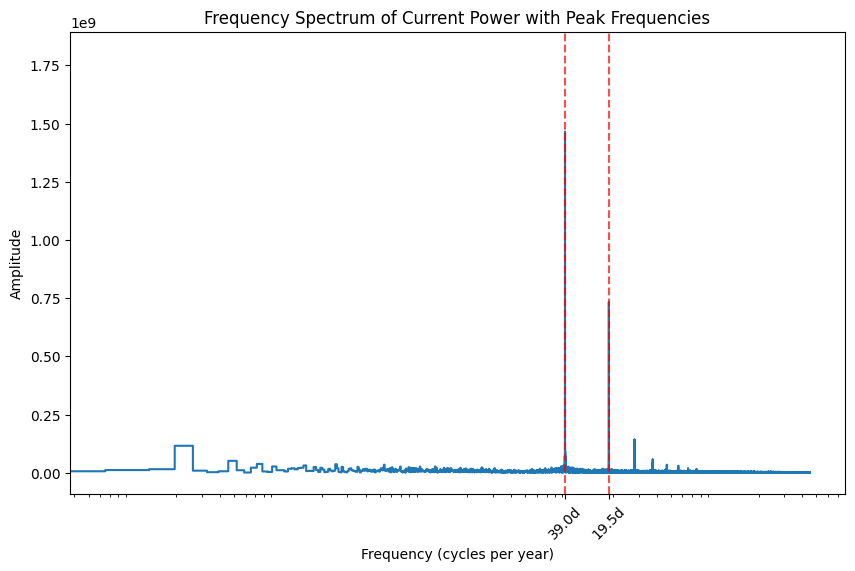

In [110]:
# Get top peaks (assuming you've already calculated them)
top_peaks = peak_frequencies[:2]  # Top 3 peaks

# Create frequency ticks including standard references and top peaks
#tick_locations = [1, 12, 52, 365.2524]  # Standard references (year, month, week, day)
tick_locations = []
tick_locations.extend(top_peaks)  # Add peak frequencies
tick_locations.sort()  # Sort them in ascending order

# Create corresponding labels
tick_labels = []
for freq in tick_locations:
    if abs(freq - 1) < 0.1:
        tick_labels.append('1/Year')
    elif abs(freq - 12) < 0.5:
        tick_labels.append('1/Month')
    elif abs(freq - 52) < 2:
        tick_labels.append('1/Week')
    elif abs(freq - 365.2524) < 10:
        tick_labels.append('1/Day')
    else:
        period_days = (1/freq) * 365.2524
        if period_days < 1:
            tick_labels.append(f'{period_days*24:.1f}h')
        else:
            tick_labels.append(f'{period_days:.1f}d')

plt.step(f_per_year, np.abs(fft))
plt.xscale('log')

# Apply the customized ticks to your plot
plt.xticks(tick_locations, labels=tick_labels, rotation=45)

# Add a vertical line at each peak for emphasis
for freq in top_peaks:
    plt.axvline(x=freq, color='r', linestyle='--', alpha=0.7)

plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Current Power with Peak Frequencies')

In [111]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [112]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

[Text(0, 0, 'ambient_temperature'),
 Text(1, 0, 'current_power'),
 Text(2, 0, 'temperature_measurement'),
 Text(3, 0, 'total_irradiation'),
 Text(4, 0, 'utci_mean'),
 Text(5, 0, 'cc'),
 Text(6, 0, 'q'),
 Text(7, 0, 'r'),
 Text(8, 0, 't'),
 Text(9, 0, 'u'),
 Text(10, 0, 'v'),
 Text(11, 0, 'fal'),
 Text(12, 0, 'slhf'),
 Text(13, 0, 'sp'),
 Text(14, 0, 'sshf'),
 Text(15, 0, 'ssr'),
 Text(16, 0, 'ssrd'),
 Text(17, 0, 'str'),
 Text(18, 0, 'strd'),
 Text(19, 0, 't2m'),
 Text(20, 0, 'tp'),
 Text(21, 0, 'u10'),
 Text(22, 0, 'v10'),
 Text(23, 0, 'Day sin'),
 Text(24, 0, 'Day cos'),
 Text(25, 0, 'Year sin'),
 Text(26, 0, 'Year cos')]

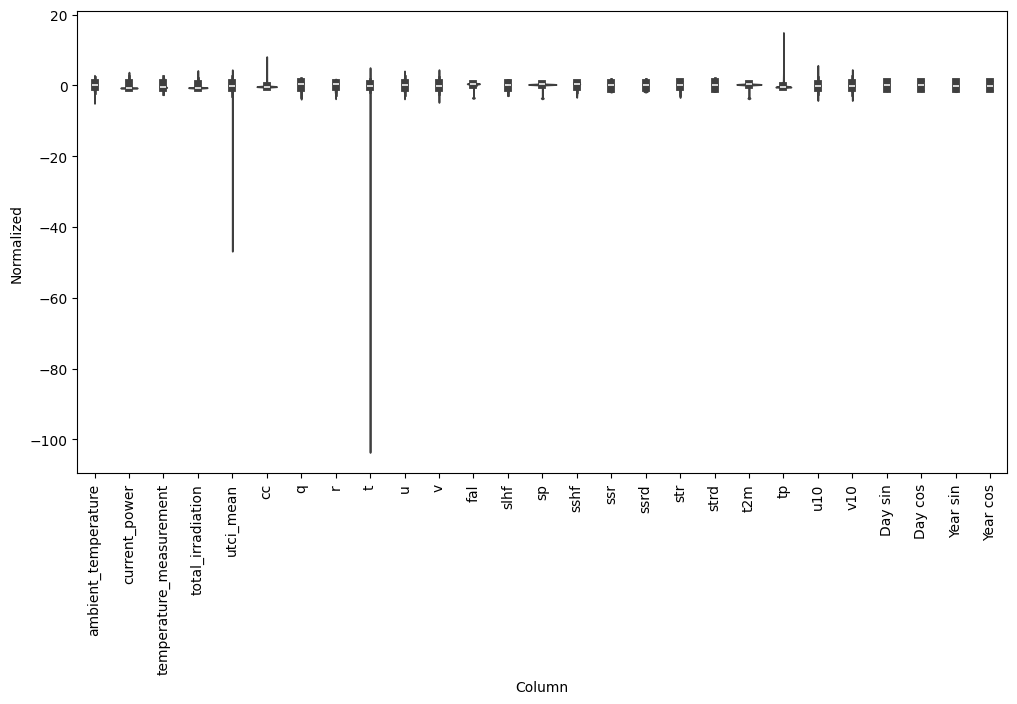

In [113]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
ax.set_xticks(range(len(df.keys())))
ax.set_xticklabels(df.keys(), rotation=90)

In [114]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='current_power', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [15min]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
    
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result
  
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [115]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['current_power'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['current_power']

In [116]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['current_power'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['current_power']

In [117]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [118]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 27)
Output shape: (32, 1, 1)


In [119]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [120]:
val_performance = {}
performance = {}

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1518 - mean_absolute_error: 0.2352 - val_loss: 0.0580 - val_mean_absolute_error: 0.1403
Epoch 2/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0580 - mean_absolute_error: 0.1373 - val_loss: 0.0464 - val_mean_absolute_error: 0.1145
Epoch 3/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0515 - mean_absolute_error: 0.1191 - val_loss: 0.0442 - val_mean_absolute_error: 0.1076
Epoch 4/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0503 - mean_absolute_error: 0.1142 - val_loss: 0.0438 - val_mean_absolute_error: 0.1058
Epoch 5/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0501 - mean_absolute_error: 0.1132 - val_loss: 0.0436 - val_mean_absolute_error: 0.1050
Epoch 6/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0501 - mean_absolute_error: 0.1131 - val_loss: 0.0437 - val_mean_absolute_error: 0.1049
Epoch 7/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0501 - mean_absolute_err

In [121]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 27)
Output shape: (32, 24, 1)


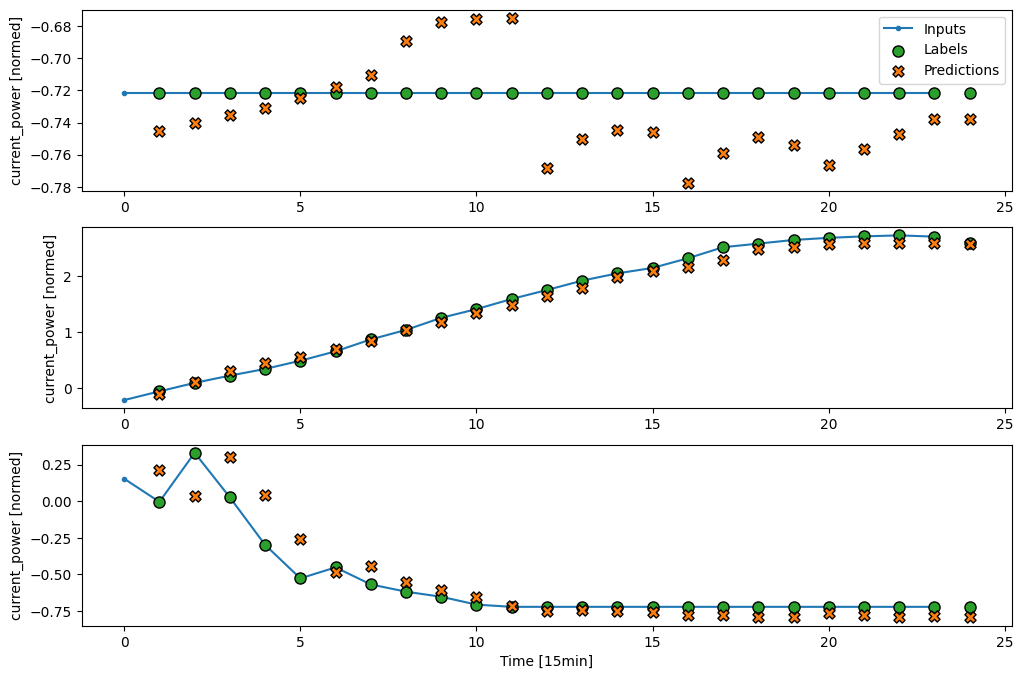

In [122]:
wide_window.plot(linear)

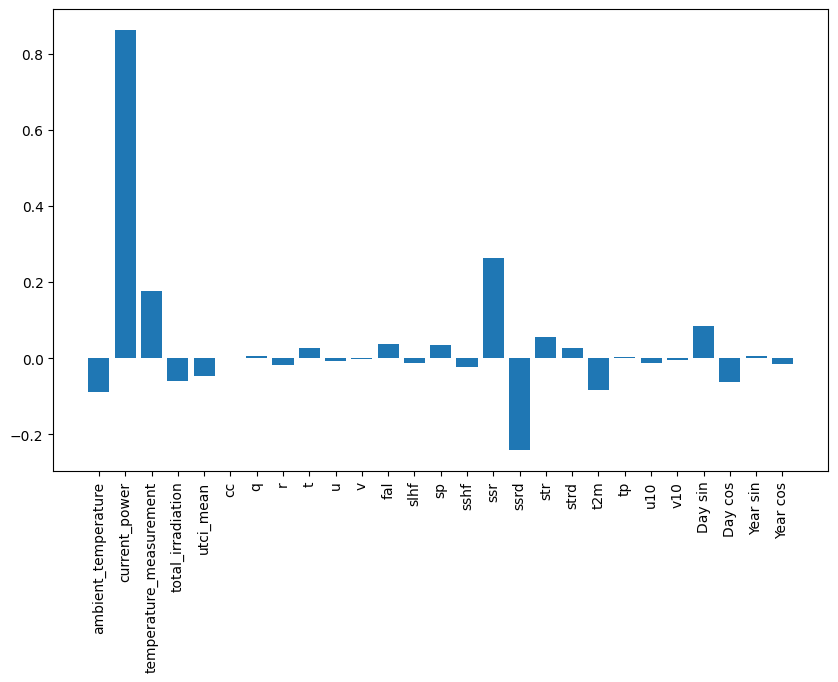

In [123]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [124]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0544 - mean_absolute_error: 0.1253 - val_loss: 0.0425 - val_mean_absolute_error: 0.1046
Epoch 2/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0466 - mean_absolute_error: 0.1042 - val_loss: 0.0436 - val_mean_absolute_error: 0.1038
Epoch 3/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0457 - mean_absolute_error: 0.1002 - val_loss: 0.0423 - val_mean_absolute_error: 0.0976
Epoch 4/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0450 - mean_absolute_error: 0.0973 - val_loss: 0.0410 - val_mean_absolute_error: 0.0920
Epoch 5/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0445 - mean_absolute_error: 0.0953 - val_loss: 0.0441 - val_mean_absolute_error: 0.0993
Epoch 6/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0443 - mean_absolute_error: 0.0950 - val_loss: 0.0395 - val_mean_absolute_error: 0.0891
Epoch 7/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0441 - mean_absolute_err

In [125]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['current_power'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['current_power']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

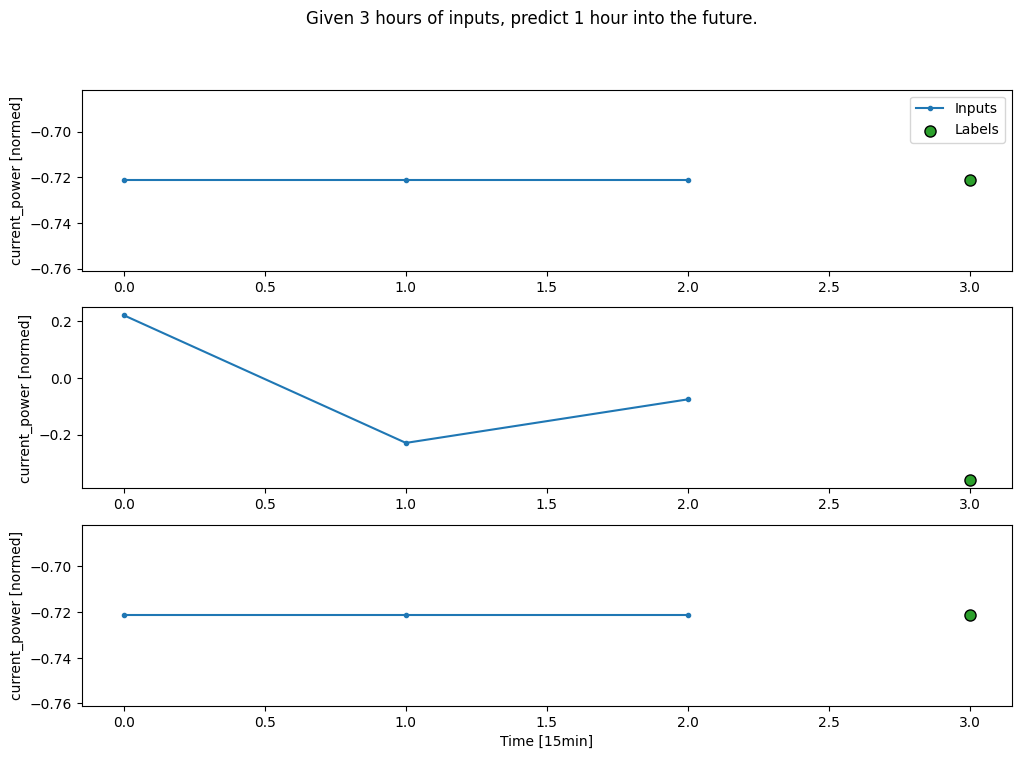

In [126]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

In [127]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [128]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 27)
Output shape: (32, 1, 1)


In [129]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0381 - mean_absolute_error: 0.0882


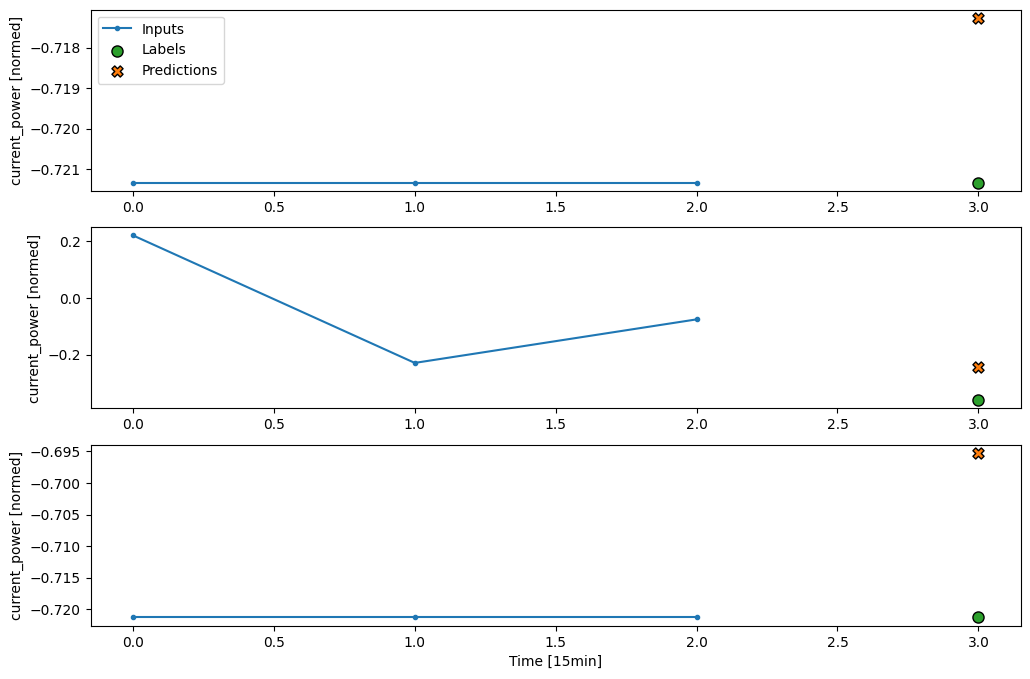

In [130]:
conv_window.plot(multi_step_dense)

In [131]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [132]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 27)
Output shape: (32, 1, 1)


In [133]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0391 - mean_absolute_error: 0.0894


In [134]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 27)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [135]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['current_power'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['current_power']

In [136]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 27)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


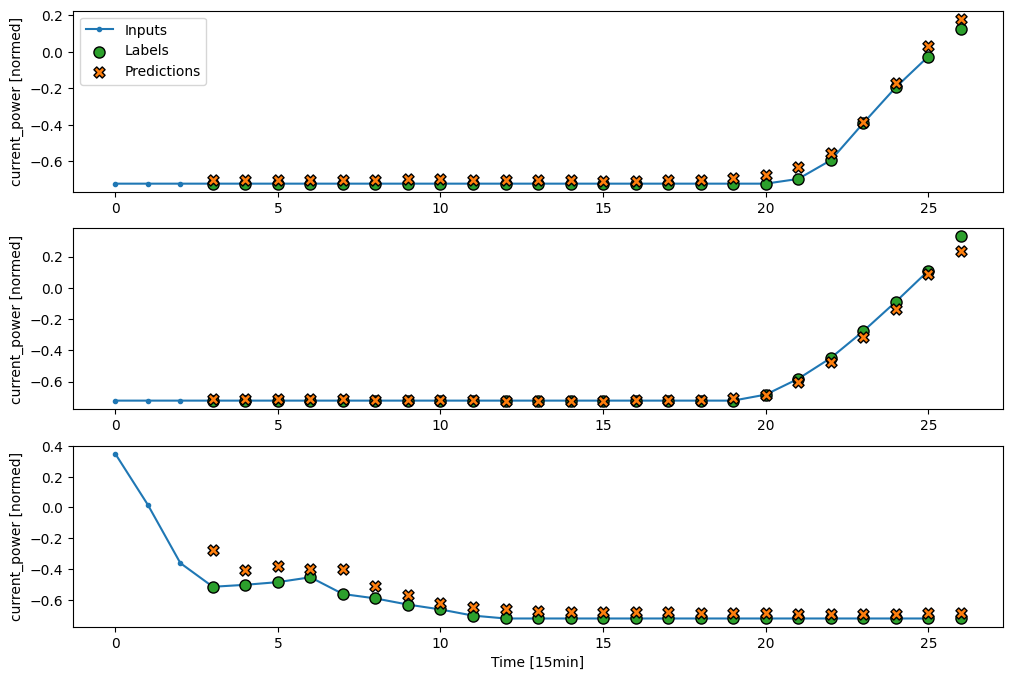

In [137]:
wide_conv_window.plot(conv_model)

In [138]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [139]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 27)
Output shape: (32, 24, 1)


In [140]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0563 - mean_absolute_error: 0.1179 - val_loss: 0.0381 - val_mean_absolute_error: 0.0866
Epoch 2/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0412 - mean_absolute_error: 0.0892 - val_loss: 0.0372 - val_mean_absolute_error: 0.0844
Epoch 3/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0394 - mean_absolute_error: 0.0863 - val_loss: 0.0381 - val_mean_absolute_error: 0.0833
Epoch 4/20
3024/3024 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0379 - mean_absolute_error: 0.0848 - val_loss: 0.0389 - val_mean_absolute_error: 0.0854


In [141]:
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0389 - mean_absolute_error: 0.0854


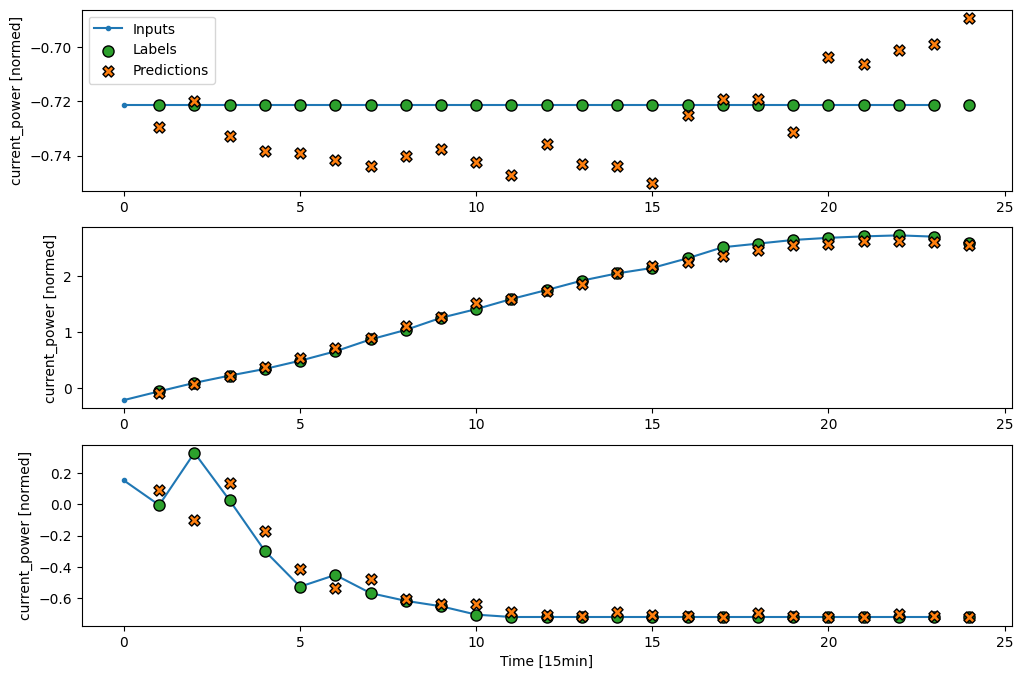

In [142]:
wide_window.plot(lstm_model)

In [143]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [144]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0373 - mean_absolute_error: 0.0889

CPU times: user 4min 7s, sys: 41.6 s, total: 4min 49s
Wall time: 2min 18s


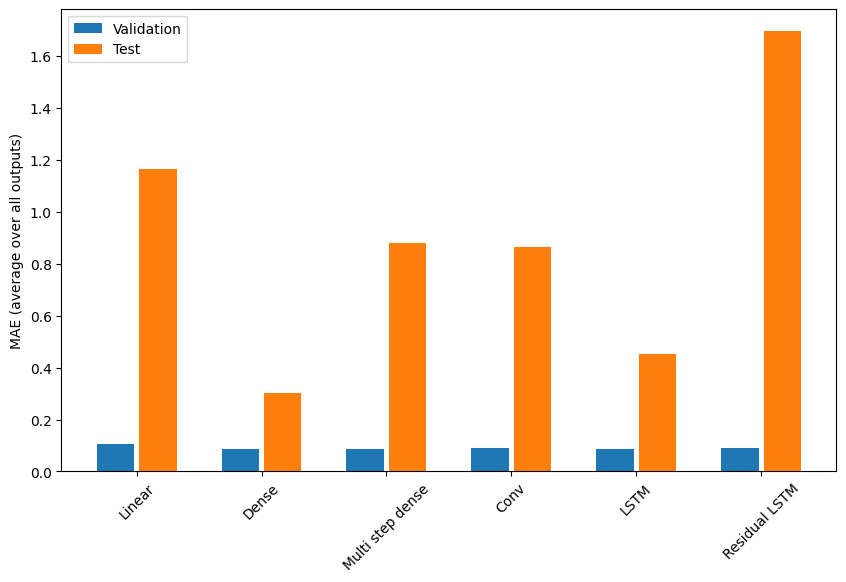

In [145]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()